### Quadrinôme :
- BOULARIACHE Abdessamed
- KEMOUM Meroua
- MAHIDDINE Mohamed Amine
- TAZIR reda

# Projet de fin de semestre - Spam Classification -

- Goal : A potential goal would be to learn how to classify emails as spam or non-spam.
- Dataset : The dataset is a set consisting of emails as text data and their spam and non-spam labels.
- Category : Since we are working with class labels (spam, non-spam), this is a supervised learning problem.
- Measure Performance : Predict class labels in the test dataset and count the number of correct predictions to asses the prediction accuracy.

In [76]:
import os
import re
import pandas as pd
import numpy as np

from email import message_from_string
from email import policy
from email import message

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Préparation des données

#### Fonction pour extraire le corps d'un email

In [77]:
from email import message_from_bytes
def email_body(content) :
    msg = message_from_bytes(content, policy=policy.default)
    strtext = ''
    if msg.is_multipart():
        for part in msg.walk():
            payload = part.get_payload(decode=True) #returns a bytes object
            
            if payload is None:
                        continue

            strtext = strtext + payload.decode(errors="ignore") #utf-8 is default

    else:
        payload = msg.get_payload(decode=True)
        strtext = payload.decode(errors="ignore")

    return strtext

### Importation des emails

In [78]:

# extract emails main content from emails directory
def import_emails_from_directory(path) : 

    emails = []
    for filename in os.listdir(path) :
        try:
            file = open(os.path.join(path, filename), "rb")
            content = file.read()
            
            emails.append(email_body(content))
            
        except OSError as exception:
            print(exception)
    return emails


In [79]:
path = "ressources\spam_2" #"ressources/test" #
x_spam = []
x_spam = import_emails_from_directory(path)

In [80]:
len(x_spam)

1396

In [82]:
path = "ressources\easy_ham_2" 
x_ham = []
x_ham = import_emails_from_directory(path)

In [83]:
len(x_ham)

1400

In [84]:
def nettoyage_email(email):
    
    # Conversion en minuscules.
    email = email.lower()
    
    # Suppression de balises HTML
    email = re.sub('<[^<>]+>', '', email)
    
    # Normalisation des adresses e-mail : toutes les adresses e-mail devront être remplacées avec le texte "emailaddr".
    email = re.sub('[^\s]+@[^\s]+', 'emailaddr', email)

    # Normalisation des URL : Toutes les URL devront être remplacées par le texte « httpaddr ».
    regex = r"[(http(s)?):\/\/(www\.)?a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)"
    email = re.sub(regex, 'httpaddr', email)
    
    # Normalisation des nombres : Tous les nombres devront être remplacés par le texte "number".
    email = re.sub('[0-9]+', ' number ', email)
    
    # Normalisation des dollars : Tous les signes dollar ($)devront être remplacés par le texte "dollar".
    email = re.sub('[$]+', ' dollar ', email)
     
    # Suppression des non-mots : les non-mots et la ponctuation devront être supprimés. Tous les espaces
    # blancs (onglets, nouvelles lignes, espaces) devront être remplacés par un seul espace.
    email = re.sub('[^A-Za-z]+', ' ', email)
                       
    # Radicalisation de mots : Les mots devront être réduits à leur forme radicale.
        # ex : "discounts", "discounted" et "discounting" devront être tous remplacé par " discount"
        
    nltk.download('punkt', quiet=True) #download required package for tokenization
    tokenized_email = word_tokenize(email)
    
    liste_tokens = []
    
    for token in tokenized_email :
        
        # Create the stemmer.
        stemmer = SnowballStemmer("english")
        
        # Stem the word.
        token = stemmer.stem(token)
        
        #ignorer une chaine vide
        if not len(token): 
            continue
        
        liste_tokens.append(token)
    
    email = " ".join(liste_tokens)
    
    return email

# Organisation des caractéristiques

### Features

In [15]:
emails = []
# ajout des emails spam à la liste des emails 
for x in x_spam :
    emails.append(nettoyage_email(x))
# ajout des emails non-spam à la liste des emails 
for x in x_ham :
    emails.append(nettoyage_email(x))

In [32]:
X = np.asarray(emails)

In [33]:
X.shape

(2796,)

### Labels

- spam (y = 1) 
- non-spam (y = 0).

In [21]:
y_size = len(x_spam)+len(x_ham)
Y = np.zeros(y_size).astype(int)
#fill first half of "Y" with ones
Y[:len(x_spam)-1] = 1


In [22]:
Y

array([1, 1, 1, ..., 0, 0, 0])

In [34]:
Y.shape

(2796,)

## Splitting the data into training data and test data

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [37]:
print(X_train.shape)
print(X_test.shape)

(2236,)
(560,)


# Construction du vocabulaire et Extraction des caractéristiques

#### Vectorization en utilisant le module TfidfVectorizer
- Comme les données textuelles ne peuvent pas être utilisés directement, nous utiliseront dans ce qui suit la Fonction de vectorisation "TF-IDF" présente dans la librairie scikit-learn.
Cette technique nous permet de traduire les données textuelles sous formes de vecteur numérique représentant la fréquence d'apparition des mots par un indicateur de similarité (si ce mot est commun ou rare dans tous les documents). 
Pour ce projet on éliminera les mots qui se produisent rarement dans l'ensemble de nos données.

In [42]:
# Stop-words filtering : ignore words like “and”, “the”, “him”, which are presumed to be uninformative

#min_df is used for removing terms that appear too infrequently
#min_df = 0.01 means "ignore terms that appear in less than 1% of the documents"

tfidf_vectorizer = TfidfVectorizer(min_df = 0.01, stop_words=list(ENGLISH_STOP_WORDS))

X_train_features = tfidf_vectorizer.fit_transform(X_train).toarray()

X_test_features = tfidf_vectorizer.transform(X_test).toarray()

feature_names = tfidf_vectorizer.get_feature_names_out()

df = pd.DataFrame(X_train_features, columns= feature_names)
df["label"] = Y_train
df


,abil,abl,abov,absolut,abus,ac,accept,access,accord,account,...,wrote,www,yahoo,yeah,year,yes,york,zero,zip,label
0,0.0000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.069299,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.053850,0.000000,0.0,0.0,0.000000,1
1,0.0000,0.000000,0.0,0.0,0.086600,0.0,0.063483,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.064818,0.0,0.0,0.000000,1
2,0.0000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.056958,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0
3,0.0000,0.000000,0.0,0.0,0.217813,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1
4,0.0000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231,0.0284,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.088870,0.014853,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0
2232,0.0000,0.005356,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.014257,0.0,...,0.000000,0.0,0.0,0.0,0.004143,0.000000,0.0,0.0,0.000000,1
2233,0.0000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.068852,1
2234,0.0000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.099536,1


In [43]:
df.shape

(2236, 1597)

In [44]:
feature_names.shape

(1596,)

### Extraction de la liste complète du vocabulaire après construction

In [45]:
vocab_file = open(r"resultats\vocab.txt", "w")
for element in feature_names:
    vocab_file.write(element + "\n")
vocab_file.close()

### Extraction des données après construction

In [46]:
df.to_csv(r'resultats\data1.csv')

# Classification

## Régression logistique

In [49]:
logreg = LogisticRegression()
logreg.fit(X_train_features, Y_train)

LogisticRegression()

#### Prediction sur les données d'entrainement

In [51]:
y_pred = logreg.predict(X_train_features)
accuracy_training = accuracy_score(Y_train, y_pred)

In [52]:
print("accuracy on training data : ", accuracy_training)

accuracy on training data :  0.9883720930232558


#### Prediction sur les données de test

In [53]:
y_pred_test = logreg.predict(X_test_features)
accuracy_test = accuracy_score(Y_test, y_pred_test)

In [54]:
print("accuracy on test data : ", accuracy_test)

accuracy on test data :  0.975


#### Roc curve

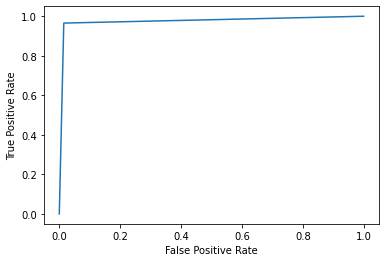

In [58]:
fpr, tpr, _ = roc_curve(Y_test,  y_pred_test)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Naive Bayes

In [61]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_features, Y_train)

MultinomialNB()

#### Prediction sur les données d'entrainement

In [62]:
y_pred = naive_bayes.predict(X_train_features)
accuracy_training = accuracy_score(Y_train, y_pred)

In [63]:
print("accuracy on training data : ", accuracy_training)

accuracy on training data :  0.9798747763864043


#### Prediction sur les données de test

In [64]:
y_pred_test = naive_bayes.predict(X_test_features)
accuracy_test = accuracy_score(Y_test, y_pred_test)

In [65]:
print("accuracy on test data : ", accuracy_test)

accuracy on test data :  0.9696428571428571


#### Roc curve

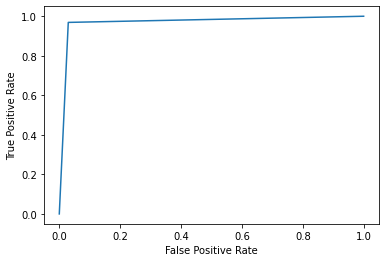

In [66]:
fpr, tpr, _ = roc_curve(Y_test,  y_pred_test)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## SVM

In [69]:
svm = svm.LinearSVC(C=0.1, random_state=1)
svm.fit(X_train_features, Y_train)

LinearSVC(C=0.1, random_state=1)

#### Prediction sur les données d'entrainement

In [70]:
y_pred = svm.predict(X_train_features)
accuracy_training = accuracy_score(Y_train, y_pred)

In [71]:
print("accuracy on training data : ", accuracy_training)

accuracy on training data :  0.9879248658318426


#### Prediction sur les données de test

In [72]:
y_pred_test = svm.predict(X_test_features)
accuracy_test = accuracy_score(Y_test, y_pred_test)

In [73]:
print("accuracy on test data : ", accuracy_test)

accuracy on test data :  0.9767857142857143


#### Roc curve

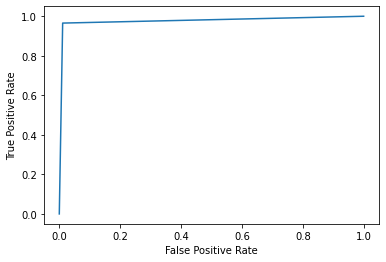

In [74]:
fpr, tpr, _ = roc_curve(Y_test,  y_pred_test)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()